<a href="https://colab.research.google.com/github/guramritpalsaggu/NLP/blob/master/Story_Genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

Loading the train and test files

In [0]:
train = pd.read_csv('/content/drive/My Drive/HackerearthSME/dataset/train.csv')
test = pd.read_csv('/content/drive/My Drive/HackerearthSME/dataset/test.csv')

In [0]:
train.head()

,ID,Release Year,Title,Language,Writer,No. of readers,Story,Genre
0,MID_3037,2014,aiMudhrnalac A Vis,Tamil,Thiraivannan,1527,The title “Adra Machan Visilu” fellows blow a ...,type0
1,MID_4958,2005,Oamthm ni OS,Hindi,Farah Khan,582,"Om Prakash Makhija, a junior artist in 1970s H...",type1
2,MID_10092,2018,EtNehr ir,Tamil,M.Jaya Pradeep,15751,Karthik (Richard) gets a call from his friend ...,type3
3,MID_3723,1992,W'rHs annaa,English,Menahem Golan,2918,Hannah Senesh was a real-life Hungarian Jew wh...,type4
4,MID_9675,1986,haaasa lBasoBbhobal,Bengali,Tarun Majumdar,12071,Keya (Debashree Roy) is a college student who ...,type1


**Exploratory Data Analysis and Data Pre-processing**

Their is no missing values in the dataset.

In [0]:
train.isnull().any(),test.isnull().any()

(ID                False
 Release Year      False
 Title             False
 Language          False
 Writer            False
 No. of readers    False
 Story             False
 Genre             False
 dtype: bool, ID                False
 Release Year      False
 Title             False
 Language          False
 Writer            False
 No. of readers    False
 Story             False
 dtype: bool)

Distribution is even of all the Genre's.

In [0]:
train['Genre'].value_counts()

type2    1102
type4    1100
type0    1094
type1     909
type3     845
Name: Genre, dtype: int64

Genre column need to be encoded and for that will use get_dummies function of pandas.

In [0]:
train = pd.get_dummies(train, columns=['Genre'])
train.head()

,ID,Release Year,Title,Language,Writer,No. of readers,Story,Genre_type0,Genre_type1,Genre_type2,Genre_type3,Genre_type4
0,MID_3037,2014,aiMudhrnalac A Vis,Tamil,Thiraivannan,1527,The title “Adra Machan Visilu” fellows blow a ...,1,0,0,0,0
1,MID_4958,2005,Oamthm ni OS,Hindi,Farah Khan,582,"Om Prakash Makhija, a junior artist in 1970s H...",0,1,0,0,0
2,MID_10092,2018,EtNehr ir,Tamil,M.Jaya Pradeep,15751,Karthik (Richard) gets a call from his friend ...,0,0,0,1,0
3,MID_3723,1992,W'rHs annaa,English,Menahem Golan,2918,Hannah Senesh was a real-life Hungarian Jew wh...,0,0,0,0,1
4,MID_9675,1986,haaasa lBasoBbhobal,Bengali,Tarun Majumdar,12071,Keya (Debashree Roy) is a college student who ...,0,1,0,0,0


Genre of the movie depend on the **Story** only as other parameters given here are not useful for us.

Split the dependant and independant variables

In [0]:
labels = ["Genre_type0", "Genre_type1", "Genre_type2", "Genre_type3", "Genre_type4"]
y_train = train[labels].values
list_sentences_train = train["Story"]
list_sentences_test = test["Story"]

The approach that we are taking is to feed the "Story" into the LSTM(Long Short-Term Memory) as part of the neural network but we can't just feed the words as it is.

So this is what we are going to do:

1. Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

In [0]:
max_features = 70000        # Number of unique words in the dictionary when tokenizing the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Now, if we look at "list_tokenized_train", we will see that Keras has turned our words into index representation for us.

In [0]:
list_tokenized_train[:1]

But there's still 1 problem! What if some Stories are terribly long, while some are short. Wouldn't our indexed-sentence look like this:

Story #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Story #2: [1,2,5,6,7]

And we have to feed a stream of data that has a consistent length(fixed number of features).

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones.

One of the ways to go about it is to see the distribution of the number of words in sentences.

In [0]:
totalNumWords = [len(one_story) for one_story in list_tokenized_train]

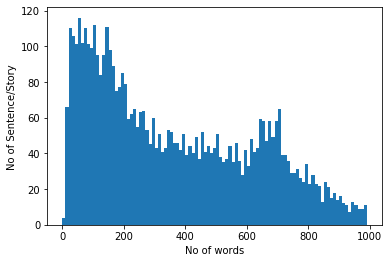

In [0]:
plt.hist(totalNumWords, bins = np.arange(0, 1000, 10))
plt.xlabel('No of words')
plt.ylabel('No of Sentence/Story')
plt.show()

From the above plot we can see the distribution of number of words against stories and see that most of stories has length less than 150. We can also try out other values for maxlen but we need to keep in mind that length should not be too small as it will result in lose of some useful features and too long will make it difficult to store these values.

In [0]:
maxlen = 150
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

**Build Model**

Now as we are finished preprocessing the text, we will now proceed to build the model. Model which we have build here is Bidirectional LSTM with Convolution.Our model consists of an initial LSTM layer which will receive word embeddings. The intuition is that its output tokens will store information not only of the initial token, but also any previous tokens, the LSTM layer is generating a new encoding for the original input. The output of the LSTM layer is then fed into a convolution layer which we expect will extract local features. Finally the convolution layer’s output will be pooled to a smaller dimension and ultimately output with genre of the text.

The inputs into our networks is our list of encoded sentences. We begin by 
defining an Input layer that accepts a list of sentences that has a dimension of 150.

![alt text](https://drive.google.com/uc?id=16z0Y0YZ4uTwSM9cS6Ry6dD2Uwdc3H5qI)

In [0]:
sequence_input = Input(shape=(maxlen, ))  #maxlen=150 as defined earlier

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.

The output of the Embedding layer is a list of the coordinates of the words in this vector space.

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that we can tune and experiment.

In [0]:
embed_size = 300
x = Embedding(max_features, embed_size)(sequence_input)

Imagine that the LSTM is split between 2 hidden states for each time step. As the sequence of words is being feed into the LSTM in a forward fashion, there's another reverse sequence that is feeding to the different hidden state at the same time. You might noticed later at the model summary that the output dimension of LSTM layer has doubled to 120 because 60 dimensions are used for forward, and another 60 are used for reverse.

The greatest advantage in using Bidirectional LSTM is that when it runs backwards you preserve information from the future and using the two hidden states combined, you are able in any point in time to preserve information from both past and future.

LSTM Dropout is a probabilistic drop out layer on the inputs in each time step.

Recurrent drop out is something like a dropout mask that applies drop out between the hidden states throughout the recursion of the whole LSTM network.

Output from the previous embedding layer which outputs a 3-D tensor of (None,150, 300) into the LSTM layer.

![alt text](https://drive.google.com/uc?id=1y-WY85tJLg3EJlWvS2dzdLsVTmd9x_aJ)

In [0]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is used in CNN to reduce the dimensionality of image data. We go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 5 labels, and the sigmoid function will keep the output between the bounds of 0 and 1.

In [0]:
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation="sigmoid")(x)

Model will optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are dealing with a binary classification.

In [0]:
model = Model(inputs=sequence_input, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=1e-3),
                  metrics=['accuracy'])

In [0]:
model.summary()

Saving only the best model and using Early Stopping to prevent overfitting.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=233)

In [0]:
filepath="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

In [0]:
batch_size = 128
epochs = 5
model.fit(X_train, y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data = (X_val,y_val),
          callbacks = callbacks_list,
          verbose=1)

Train on 4545 samples, validate on 505 samples
Epoch 1/5
4545/4545 [==============================] - 27s 6ms/step - loss: 0.0442 - acc: 0.9900 - val_loss: 0.4655 - val_acc: 0.8515

Epoch 00001: val_acc did not improve from 0.85743
Epoch 2/5
4545/4545 [==============================] - 28s 6ms/step - loss: 0.0197 - acc: 0.9963 - val_loss: 0.5125 - val_acc: 0.8515

Epoch 00002: val_acc did not improve from 0.85743
Epoch 3/5
4545/4545 [==============================] - 28s 6ms/step - loss: 0.0125 - acc: 0.9976 - val_loss: 0.5093 - val_acc: 0.8634

Epoch 00003: val_acc improved from 0.85743 to 0.86337, saving model to weights_base.best.hdf5
Epoch 4/5
4545/4545 [==============================] - 28s 6ms/step - loss: 0.0113 - acc: 0.9974 - val_loss: 0.5810 - val_acc: 0.8503

Epoch 00004: val_acc did not improve from 0.86337
Epoch 5/5
4545/4545 [==============================] - 27s 6ms/step - loss: 0.0085 - acc: 0.9984 - val_loss: 0.5812 - val_acc: 0.8539

Epoch 00005: val_acc did not impro

In [0]:
model.load_weights(filepath)
print('Predicting....')
y_pred = model.predict(X_test, verbose=1)

Predicting....
2361/2361 [==============================] - 18s 8ms/step


We have achieved the validation accuracy of about 86% here. We have experimented with various parameters and the accuracy varies around 85+-2%.

TODOs: We could use pretrained embedding such as Glove, Fasttext, Word2Vec etc and see if could improve our results.

Now we need to export our results into the submission.csv 

In [0]:
y_pred = pd.DataFrame(y_pred)
y = y_pred.idxmax(axis = 1)
dic = {0:"type0", 1:"type1", 2:"type2", 3:"type3", 4:"type4"}
submission = pd.read_csv('/content/drive/My Drive/HackerearthSME/dataset/test.csv')
submission = submission.drop(["Release Year","Title","Language","Writer","No. of readers","Story"], axis=1)
submission['Genre'] = y
submission.Genre = submission.Genre.map(dic)
submission.to_csv('submission.csv', index = False)

In [0]:
y_pred

array([[1.71998143e-03, 4.46140766e-05, 3.85880470e-04, 9.97099876e-01,
        8.87542963e-04],
       [5.78790903e-04, 3.57627869e-07, 1.15783125e-01, 3.41236591e-05,
        9.82372046e-01],
       [9.42593455e-01, 1.44541264e-04, 2.60680914e-04, 1.72734261e-04,
        1.36012316e-01],
       ...,
       [4.48822975e-05, 8.10325146e-05, 5.94251037e-01, 4.94436294e-01,
        2.97397375e-04],
       [3.89816463e-02, 2.11596489e-06, 5.12003899e-05, 1.87414974e-01,
        1.46663189e-01],
       [9.68728840e-01, 6.61662221e-03, 9.43094492e-04, 3.66657972e-04,
        4.18593921e-03]], dtype=float32)

Apart from LSTM Network, we have tried Logistic Regression, Naive Bayes but the cross validation score was around 80-82% with TF-IDF vectorization for words and characters

TODOS: We can tune the hyperparameter's using randomized grid search and improve our results.
Some more text classification methods and text preprocessing can be tried on to improve the accuracy.

In [0]:
class_names = ['Genre_type0','Genre_type1','Genre_type2','Genre_type3','Genre_type4']
train_text = train['Story']
test_text = test['Story']
all_text = pd.concat([train_text, test_text])

In [0]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [0]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [0]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [0]:
scores = []
submission = pd.DataFrame.from_dict({'ID': test['ID']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


CV score for class Genre_type0 is 0.7833663588518975
CV score for class Genre_type1 is 0.8199999858865304
CV score for class Genre_type2 is 0.7817822395159268
CV score for class Genre_type3 is 0.8326732934110327
CV score for class Genre_type4 is 0.7835643002612404
Total CV score is 0.8002772355853255


In [0]:
cross_val_score(model, train_text, y_train, cv=3, scoring = None)
